In [1]:
import os
os.chdir('/home/fmg2/v-thanh/Code/source/Time_Series_Backdoor_Attack') 
cwd = os.getcwd()
print("Current working directory:", cwd)

import sys
import yaml
import warnings
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

import umap
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from utils.constants import RESULT_DIR, SRC_DIR, SEED
from utils.data_handler import get_tsc_train_dataset, preprocess_data, create_dataset
from models.clf_wrapper import ClassifierWrapper
from models.trigger_gen import TriggerGenerator

warnings.filterwarnings('ignore')

np.random.seed(SEED)
tf.random.set_seed(SEED)

Current working directory: /home/fmg2/v-thanh/Code/source/Time_Series_Backdoor_Attack


2025-09-06 22:29:24.868974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757165364.976473 1584999 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757165364.985791 1584999 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757165365.319413 1584999 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757165365.319446 1584999 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757165365.319449 1584999 computation_placer.cc:177] computation placer alr

# Load dataset

In [2]:
dataset_name = "iAWE"
data_ratio = 0.05

# Attacker data
x_train_atk, y_train_atk, x_test_atk, y_test_atk = get_tsc_train_dataset(
    dataset_name=dataset_name,
    data_ratio=data_ratio,
    data_type="atk"
)

x_train_atk, y_train_atk, x_test_atk, y_test_atk, enc = preprocess_data(x_train_atk, y_train_atk, x_test_atk, y_test_atk)

# Service provider data
x_train_sp, y_train_sp, x_test_sp, y_test_sp = get_tsc_train_dataset(
    dataset_name=dataset_name,
    data_ratio=data_ratio,
    data_type="sp"
)

x_train_sp, y_train_sp, x_test_sp, y_test_sp, _ = preprocess_data(x_train_sp, y_train_sp, x_test_sp, y_test_sp)

print(f"Train data shape: {x_train_atk.shape}, Test data shape: {x_test_atk.shape}")
print(f"Train data shape (sp): {x_train_sp.shape}, Test data shape (sp): {x_test_sp.shape}")

Dataset iAWE reduced to 5.0% with stratified sampling
Shape of x_train: (31490, 120, 4), y_train: (31490,)
Shape of x_test: (7871, 120, 4), y_test: (7871,)
y_train shape before encoding: (31490,)
y_test shape before encoding: (7871,)
Dataset iAWE reduced to 5.0% with stratified sampling
Shape of x_train: (157462, 120, 4), y_train: (157462,)
Shape of x_test: (39363, 120, 4), y_test: (39363,)
y_train shape before encoding: (157462,)
y_test shape before encoding: (39363,)
Train data shape: (31490, 120, 4), Test data shape: (7871, 120, 4)
Train data shape (sp): (157462, 120, 4), Test data shape (sp): (39363, 120, 4)


In [3]:
def calculate_feature_stats_by_class(data, labels):
    """
    Calculate mean and variance of each feature for each class
    
    Args:
        data: Time series data with shape (samples, time_steps, features)
        labels: One-hot encoded labels or class indices
        
    Returns:
        Dictionary with statistics for each class and feature
    """
    
    # Convert one-hot to class indices if needed
    if len(labels.shape) > 1 and labels.shape[1] > 1:
        class_indices = np.argmax(labels, axis=1)
    else:
        class_indices = labels.flatten()
    
    unique_classes = np.unique(class_indices)
    n_features = data.shape[2]
    
    stats = {}
    
    print("=" * 60)
    print("FEATURE STATISTICS BY CLASS")
    print("=" * 60)
    print(f"Data shape: {data.shape}")
    print(f"Number of features: {n_features}")
    print(f"Number of classes: {len(unique_classes)}")
    print()
    
    for class_idx in unique_classes:
        class_mask = class_indices == class_idx
        class_data = data[class_mask]  # Shape: (n_samples_in_class, time_steps, features)
        
        print(f"Class {class_idx}: {len(class_data)} samples")
        
        feature_stats = {}
        
        for feature_idx in range(n_features):
            # Get all time series for this feature across all samples in this class
            feature_data = class_data[:, :, feature_idx]  # Shape: (n_samples_in_class, time_steps)
            
            # Calculate mean and variance across all values (samples and time steps)
            feature_mean = np.mean(feature_data)
            feature_var = np.var(feature_data)
            
            feature_stats[f'feature_{feature_idx}'] = {
                'mean': feature_mean,
                'variance': feature_var
            }
            
            print(f"  Feature {feature_idx}: mean = {feature_mean:.6f}, variance = {feature_var:.6f}")
        
        stats[f'class_{class_idx}'] = feature_stats
        print()
    
    return stats

def calculate_class_similarity(data, labels):
    """
    Calculate average similarity between each pair of classes
    
    Args:
        data: Time series data with shape (samples, time_steps, features)
        labels: One-hot encoded labels or class indices
        
    Returns:
        Dictionary with pairwise similarities and summary statistics
    """
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Convert one-hot to class indices if needed
    if len(labels.shape) > 1 and labels.shape[1] > 1:
        class_indices = np.argmax(labels, axis=1)
    else:
        class_indices = labels.flatten()
    
    unique_classes = np.unique(class_indices)
    n_classes = len(unique_classes)
    
    # Flatten data for similarity calculation
    data_flattened = data.reshape(len(data), -1)
    
    print("=" * 80)
    print("CLASS-TO-CLASS SIMILARITY ANALYSIS")
    print("=" * 80)
    print(f"Data shape: {data.shape}")
    print(f"Flattened shape: {data_flattened.shape}")
    print(f"Number of classes: {n_classes}")
    print()
    
    # Calculate class centroids (mean of all samples in each class)
    class_centroids = {}
    class_samples = {}
    
    for class_idx in unique_classes:
        class_mask = class_indices == class_idx
        class_data = data_flattened[class_mask]
        class_centroids[class_idx] = np.mean(class_data, axis=0)
        class_samples[class_idx] = class_data
        print(f"Class {class_idx}: {len(class_data)} samples")
    
    print()
    
    # Method 1: Centroid-to-centroid similarity
    print("Method 1: Centroid-to-Centroid Similarity")
    print("-" * 50)
    
    centroid_similarities = {}
    centroid_matrix = np.zeros((n_classes, n_classes))
    
    for i, class1 in enumerate(unique_classes):
        for j, class2 in enumerate(unique_classes):
            if class1 != class2:
                # Calculate cosine similarity between centroids
                centroid1 = class_centroids[class1].reshape(1, -1)
                centroid2 = class_centroids[class2].reshape(1, -1)
                similarity = cosine_similarity(centroid1, centroid2)[0, 0]
                
                centroid_similarities[(class1, class2)] = similarity
                centroid_matrix[i, j] = similarity
                
                print(f"Class {class1} ↔ Class {class2}: {similarity:.6f}")
            else:
                centroid_matrix[i, j] = 1.0  # Self-similarity is 1
    
    print()
    
    # Method 2: Average pairwise similarity between all samples
    print("Method 2: Average Sample-to-Sample Similarity")
    print("-" * 50)
    
    sample_similarities = {}
    sample_matrix = np.zeros((n_classes, n_classes))
    
    for i, class1 in enumerate(unique_classes):
        for j, class2 in enumerate(unique_classes):
            if class1 != class2:
                # Calculate all pairwise similarities between samples of two classes
                samples1 = class_samples[class1]
                samples2 = class_samples[class2]
                
                # Calculate similarity matrix between all samples
                similarity_matrix = cosine_similarity(samples1, samples2)
                avg_similarity = np.mean(similarity_matrix)
                
                sample_similarities[(class1, class2)] = avg_similarity
                sample_matrix[i, j] = avg_similarity
                
                print(f"Class {class1} ↔ Class {class2}: {avg_similarity:.6f} (based on {len(samples1)}×{len(samples2)} pairs)")
            else:
                # Self-similarity calculation
                samples = class_samples[class1]
                if len(samples) > 1:
                    similarity_matrix = cosine_similarity(samples, samples)
                    # Exclude diagonal (self-similarity = 1)
                    mask = ~np.eye(similarity_matrix.shape[0], dtype=bool)
                    avg_self_similarity = np.mean(similarity_matrix[mask])
                    sample_matrix[i, j] = avg_self_similarity
                    print(f"Class {class1} ↔ Class {class1} (within-class): {avg_self_similarity:.6f}")
                else:
                    sample_matrix[i, j] = 1.0
                    print(f"Class {class1} ↔ Class {class1} (within-class): 1.000000 (only 1 sample)")
    
    print()
    
    # Summary statistics
    print("Summary Statistics")
    print("-" * 30)
    
    # Get off-diagonal elements (between-class similarities)
    off_diag_mask = ~np.eye(n_classes, dtype=bool)
    between_class_centroid = centroid_matrix[off_diag_mask]
    between_class_sample = sample_matrix[off_diag_mask]
    
    print("Centroid-based similarities:")
    print(f"  Mean: {np.mean(between_class_centroid):.6f}")
    print(f"  Std:  {np.std(between_class_centroid):.6f}")
    print(f"  Min:  {np.min(between_class_centroid):.6f}")
    print(f"  Max:  {np.max(between_class_centroid):.6f}")
    
    print("\nSample-based similarities:")
    print(f"  Mean: {np.mean(between_class_sample):.6f}")
    print(f"  Std:  {np.std(between_class_sample):.6f}")
    print(f"  Min:  {np.min(between_class_sample):.6f}")
    print(f"  Max:  {np.max(between_class_sample):.6f}")
    
    # Within-class similarities
    within_class_similarities = np.diag(sample_matrix)
    print(f"\nWithin-class similarities:")
    print(f"  Mean: {np.mean(within_class_similarities):.6f}")
    print(f"  Std:  {np.std(within_class_similarities):.6f}")
    print(f"  Min:  {np.min(within_class_similarities):.6f}")
    print(f"  Max:  {np.max(within_class_similarities):.6f}")
    
    return {
        'centroid_similarities': centroid_similarities,
        'sample_similarities': sample_similarities,
        'centroid_matrix': centroid_matrix,
        'sample_matrix': sample_matrix,
        'class_labels': unique_classes,
        'summary_stats': {
            'between_class_centroid_mean': np.mean(between_class_centroid),
            'between_class_sample_mean': np.mean(between_class_sample),
            'within_class_mean': np.mean(within_class_similarities)
        }
    }

def plot_class_similarity_heatmaps(similarity_results, figsize=(15, 6)):
    """
    Plot heatmaps for class similarities
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    class_labels = [f"Class {i}" for i in similarity_results['class_labels']]
    
    # Centroid similarity heatmap
    sns.heatmap(similarity_results['centroid_matrix'], 
                annot=True, fmt='.4f', cmap='viridis',
                xticklabels=class_labels, yticklabels=class_labels,
                ax=ax1, cbar_kws={'label': 'Cosine Similarity'})
    ax1.set_title('Centroid-to-Centroid Similarity')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Classes')
    
    # Sample similarity heatmap
    sns.heatmap(similarity_results['sample_matrix'], 
                annot=True, fmt='.4f', cmap='plasma',
                xticklabels=class_labels, yticklabels=class_labels,
                ax=ax2, cbar_kws={'label': 'Cosine Similarity'})
    ax2.set_title('Average Sample-to-Sample Similarity')
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Classes')
    
    plt.tight_layout()
    plt.show()

def create_similarity_summary_table(similarity_results):
    """
    Create a summary table of class similarities
    """
    import pandas as pd
    
    # Create table for between-class similarities
    data = []
    
    for (class1, class2), centroid_sim in similarity_results['centroid_similarities'].items():
        sample_sim = similarity_results['sample_similarities'][(class1, class2)]
        
        data.append({
            'Class 1': class1,
            'Class 2': class2,
            'Centroid Similarity': centroid_sim,
            'Sample Similarity': sample_sim,
            'Difference': abs(centroid_sim - sample_sim)
        })
    
    df = pd.DataFrame(data)
    
    print("\nDetailed Class Similarity Table")
    print("=" * 80)
    print(df.to_string(index=False, float_format='%.6f'))
    
    return df

In [4]:
# Prepare data using PCA dimensionality reduction and flatten
def prepare_data_for_umap(data):
    if len(data) == 0:
        return np.empty((0, 0))
    
    if len(data.shape) == 3:  # (batch, time_steps, features)
        # Reshape to 2D for PCA: (batch, time_steps * features)
        batch_size = data.shape[0]
        flattened_data = data.reshape(batch_size, -1)
        return flattened_data
    return data

In [5]:
x_total = np.concatenate([x_train_atk, x_test_atk], axis=0)
x_total_reduced = prepare_data_for_umap(x_total)
y_total_reduced = np.argmax(np.concatenate([y_train_atk, y_test_atk], axis=0), axis=1)

batch_size = x_total.shape[0]
flattened_data = x_total.reshape(batch_size, -1)

umap_reducer = umap.UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1, metric='euclidean', n_jobs=-1, verbose=True)
umap_reducer.fit(x_total_reduced)
umap_reducer.verbose = False

UMAP(n_jobs=1, random_state=42, verbose=True)
Sat Sep  6 22:34:54 2025 Construct fuzzy simplicial set
Sat Sep  6 22:34:54 2025 Finding Nearest Neighbors
Sat Sep  6 22:34:54 2025 Building RP forest with 15 trees
Sat Sep  6 22:34:59 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Sep  6 22:35:09 2025 Finished Nearest Neighbor Search
Sat Sep  6 22:35:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Sep  6 22:35:36 2025 Finished embedding


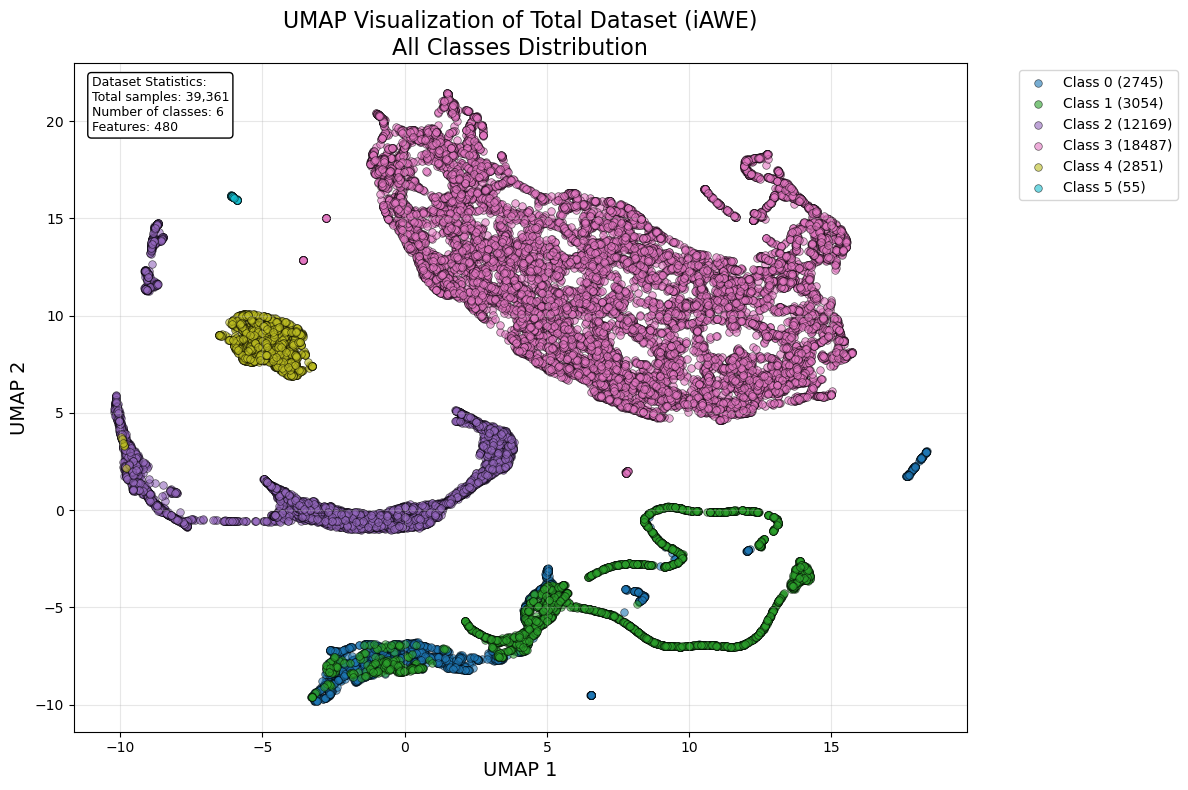

Class distribution:
Class 0: 2745 samples (7.0%)
Class 1: 3054 samples (7.8%)
Class 2: 12169 samples (30.9%)
Class 3: 18487 samples (47.0%)
Class 4: 2851 samples (7.2%)
Class 5: 55 samples (0.1%)


In [6]:
# Plot UMAP visualization for the total dataset
plt.figure(figsize=(12, 8))

# Apply UMAP to the total reduced dataset
umap_embedding = umap_reducer.transform(x_total_reduced)

# Get unique classes and create color map
unique_classes = np.unique(y_total_reduced)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))

# Plot each class with different colors
for i, class_label in enumerate(unique_classes):
    class_mask = y_total_reduced == class_label
    class_count = np.sum(class_mask)
    
    plt.scatter(umap_embedding[class_mask, 0], umap_embedding[class_mask, 1],
               c=[colors[i]], label=f'Class {class_label} ({class_count})',
               alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.title(f'UMAP Visualization of Total Dataset ({dataset_name})\nAll Classes Distribution', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# Add dataset statistics
stats_text = f"""Dataset Statistics:
Total samples: {len(x_total_reduced):,}
Number of classes: {len(unique_classes)}
Features: {x_total_reduced.shape[1]}"""

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", 
         facecolor='white', alpha=1.0), fontsize=9)

plt.tight_layout()
plt.show()

# Print class distribution
print("Class distribution:")
unique, counts = np.unique(y_total_reduced, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples ({count/len(y_total_reduced)*100:.1f}%)")

# Load the models

In [7]:
# Define the configurations for the experiment
surro_clf_name = "resnet"
target_clf_name = "transformer"
exp_no = 1
y_target = 3

# Define the epochs for training
main_epoch = 37
atk_epoch = 2
target_epoch = main_epoch - 1

# Load configurations
training_configs_path = os.path.join(SRC_DIR, "configs", "training_tsc.yaml")
finetune_configs_path = os.path.join(SRC_DIR, "configs", "finetune_surrogate.yaml")
generator_configs_path = os.path.join(SRC_DIR, "configs", "training_generator.yaml")

training_configs = yaml.safe_load(open(training_configs_path, 'r'))
finetune_configs = yaml.safe_load(open(finetune_configs_path, 'r'))
generator_configs = yaml.safe_load(open(generator_configs_path, 'r'))

input_shape = x_train_atk.shape[1:]
nb_classes = enc.categories_[0].shape[0] 
x_total = np.concatenate((x_train_atk, x_test_atk), axis=0)
y_total = np.concatenate((y_train_atk, y_test_atk), axis=0)

# Initialize the directories
main_out_dir = os.path.join(RESULT_DIR, dataset_name, "with_bd", f"bb_{surro_clf_name}_exp_{exp_no}-t_{y_target}-clf_{target_clf_name}")
target_weight_path = os.path.join(main_out_dir, f"epoch_{target_epoch}", "target_model_update", "best_model.keras")
surro_weight_path = os.path.join(main_out_dir, f"epoch_{main_epoch}", f"surro_ft_epoch_{atk_epoch}", "best_model.keras")
gen_weight_path = os.path.join(main_out_dir, f"epoch_{main_epoch}", f"generator_epoch_{atk_epoch}", "best_generator.keras")

print(f"Output dir: {main_out_dir}")
print(f"Target model weight path: {target_weight_path}")
print(f"Surrogate model weight path: {surro_weight_path}")
print(f"Generator model weight path: {gen_weight_path}")

Output dir: /home/fmg2/v-thanh/Code/results/TSBA/iAWE/with_bd/bb_resnet_exp_1-t_3-clf_transformer
Target model weight path: /home/fmg2/v-thanh/Code/results/TSBA/iAWE/with_bd/bb_resnet_exp_1-t_3-clf_transformer/epoch_36/target_model_update/best_model.keras
Surrogate model weight path: /home/fmg2/v-thanh/Code/results/TSBA/iAWE/with_bd/bb_resnet_exp_1-t_3-clf_transformer/epoch_37/surro_ft_epoch_2/best_model.keras
Generator model weight path: /home/fmg2/v-thanh/Code/results/TSBA/iAWE/with_bd/bb_resnet_exp_1-t_3-clf_transformer/epoch_37/generator_epoch_2/best_generator.keras


# Overall trends

Data contains 82 rows covering 41 main epochs
Attack epochs per main epoch: 2

Summary Statistics:
Average Surrogate ASR: 0.8738 (Max: 0.9972)
Average Target ASR: 0.7246 (Max: 0.9529)
ASR Transfer Rate: 0.8292
=== Experiment No.1 - Target class 3 Summary ===
Dataset: iAWE
Surrogate Model: resnet, Target Model: transformer

ASR Statistics:
Final Target ASR: 0.9472
Final Surrogate ASR: 0.9940
Target ASR Loss: 0.0676
Surrogate ASR Loss: 12.9211
Surrogate Finetune Train Loss: 0.0455
Surrogate Finetune Val Loss: 0.0649


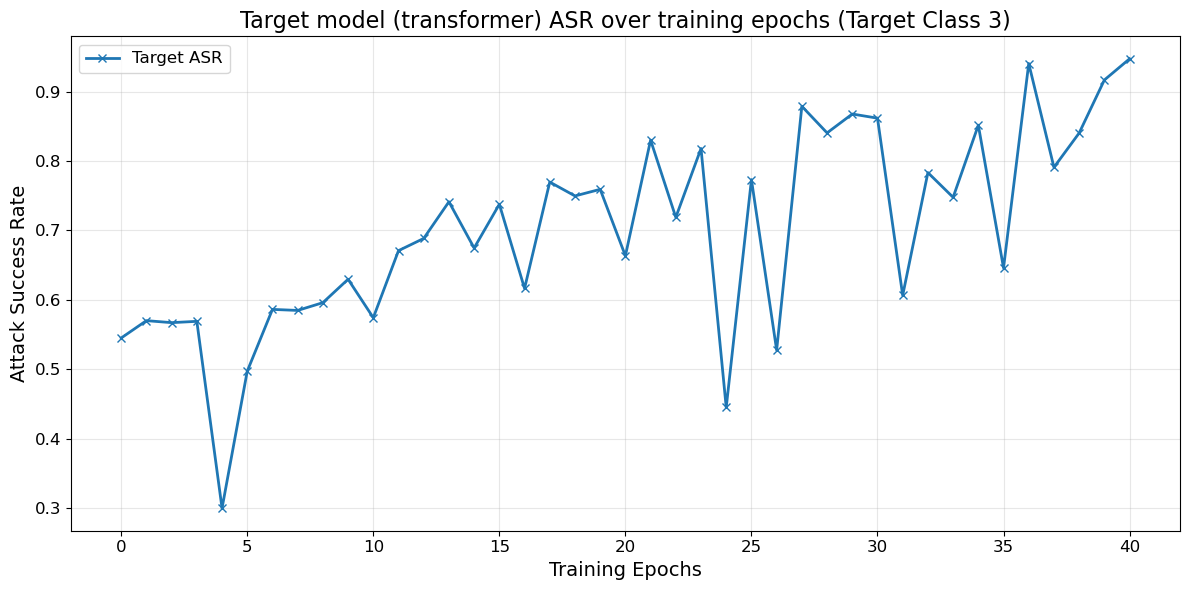

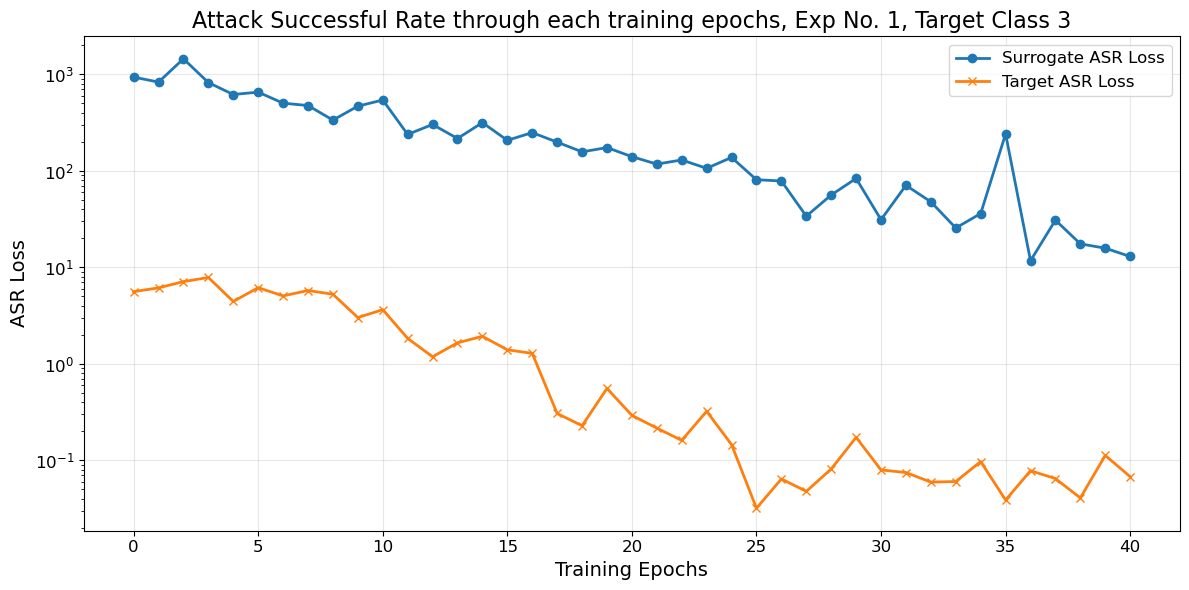

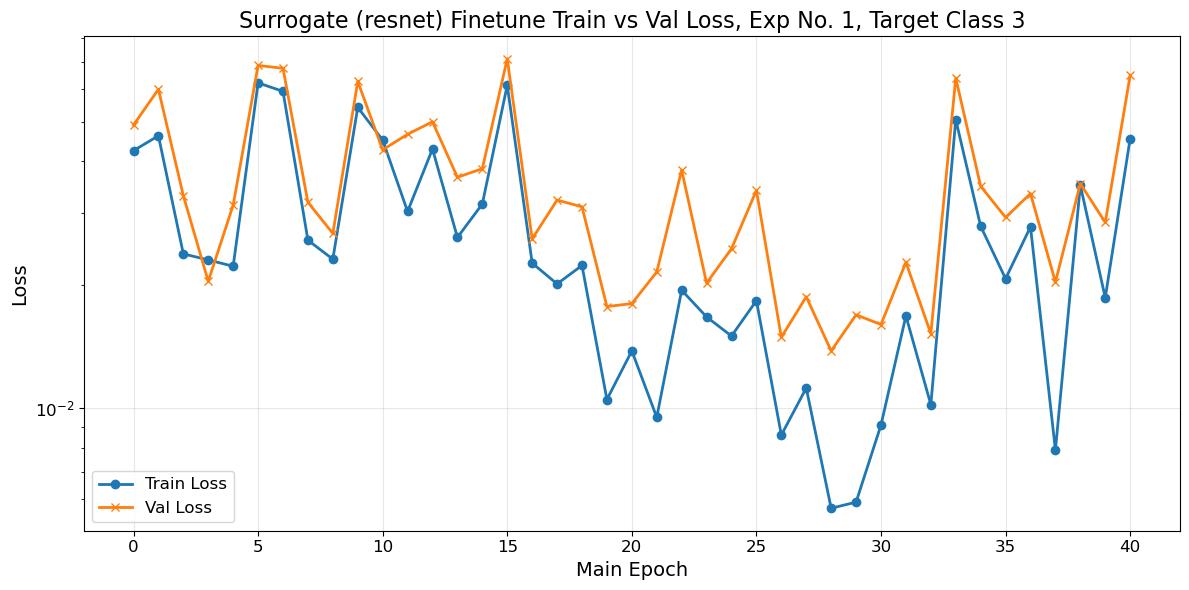

In [8]:
# Load and preprocess the attack metrics data
csv_file = os.path.join(main_out_dir, f"attack_metrics_{surro_clf_name}_to_{target_clf_name}.csv")
result_df = pd.read_csv(csv_file)

# Display basic information about the dataset
print(f"Data contains {len(result_df)} rows covering {result_df['Main Epoch'].nunique()} main epochs")
print(f"Attack epochs per main epoch: {result_df['Attack Epoch'].nunique()}")

# Display summary statistics
print("\nSummary Statistics:")
print(f"Average Surrogate ASR: {result_df['Surrogate ASR'].mean():.4f} (Max: {result_df['Surrogate ASR'].max():.4f})")
print(f"Average Target ASR: {result_df['Target ASR'].mean():.4f} (Max: {result_df['Target ASR'].max():.4f})")
print(f"ASR Transfer Rate: {result_df['Target ASR'].mean()/result_df['Surrogate ASR'].mean():.4f}")

# Display the first few rows
result_df = result_df[result_df["Attack Epoch"] == atk_epoch]
result_df = result_df.reset_index(drop=True)

# Create a summary table
print(f"=== Experiment No.{exp_no} - Target class {y_target} Summary ===")
print(f"Dataset: {dataset_name}")
print(f"Surrogate Model: {surro_clf_name}, Target Model: {target_clf_name}")

print("\nASR Statistics:")
print(f"Final Target ASR: {result_df['Target ASR'].iloc[-1]:.4f}")
print(f"Final Surrogate ASR: {result_df['Surrogate ASR'].iloc[-1]:.4f}")
print(f"Target ASR Loss: {result_df['Target ASR Loss'].iloc[-1]:.4f}")
print(f"Surrogate ASR Loss: {result_df['Surrogate ASR Loss'].iloc[-1]:.4f}")
print(f"Surrogate Finetune Train Loss: {result_df['Surrogate Finetune Train Loss'].iloc[-1]:.4f}")
print(f"Surrogate Finetune Val Loss: {result_df['Surrogate Finetune Val Loss'].iloc[-1]:.4f}")

# Plot 1: Surrogate ASR vs Target ASR
plt.figure(figsize=(12, 6))
# plt.plot(result_df.index, result_df['Surrogate ASR'], marker='o', label='Surrogate ASR', linewidth=2)
plt.plot(result_df.index, result_df['Target ASR'], marker='x', label='Target ASR', linewidth=2)
plt.xlabel('Training Epochs', fontsize=14)
plt.ylabel('Attack Success Rate', fontsize=14)
plt.title(f'Target model ({target_clf_name}) ASR over training epochs (Target Class {y_target})', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Surrogate ASR Loss vs Target ASR Loss
plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df['Surrogate ASR Loss'], marker='o', label='Surrogate ASR Loss', linewidth=2)
plt.plot(result_df.index, result_df['Target ASR Loss'], marker='x', label='Target ASR Loss', linewidth=2)
plt.xlabel('Training Epochs', fontsize=14)
plt.ylabel('ASR Loss', fontsize=14)
plt.title(f'Attack Successful Rate through each training epochs, Exp No. {exp_no}, Target Class {y_target}', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')  # Using log scale for better visualization
plt.tight_layout()
plt.show()

# Plot 3: Surrogate Finetune Train Loss vs Surrogate Finetune Val Loss
plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df['Surrogate Finetune Train Loss'], marker='o', label='Train Loss', linewidth=2)
plt.plot(result_df.index, result_df['Surrogate Finetune Val Loss'], marker='x', label='Val Loss', linewidth=2)
plt.xlabel('Main Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title(f'Surrogate ({surro_clf_name}) Finetune Train vs Val Loss, Exp No. {exp_no}, Target Class {y_target}', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')  # Using log scale for better visualization
plt.tight_layout()
plt.show()

# Load the models

In [9]:
nb_classes = 6
target_clf_train_config = training_configs.get(target_clf_name, {}).get(dataset_name, {})
target_model_wrapper = ClassifierWrapper(
    output_directory=os.path.join(RESULT_DIR, "tmp_models"),
    input_shape=input_shape,
    nb_classes=nb_classes,
    training_config=target_clf_train_config,
    clf_name=target_clf_name,
    verbose=True,
    build=True
)
target_model_wrapper.model.load_weights(target_weight_path)
target_model_wrapper.model.trainable = False

I0000 00:00:1757165898.884701 1584999 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38485 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:61:00.0, compute capability: 8.0


In [10]:
surrogate_clf_train_config = training_configs.get(surro_clf_name, {}).get(dataset_name, {})
surro_model_wrapper = ClassifierWrapper(
    output_directory=os.path.join(RESULT_DIR, "tmp_models"),
    input_shape=input_shape,
    nb_classes=nb_classes,
    training_config=surrogate_clf_train_config,
    clf_name=surro_clf_name,
    verbose=True,
    build=True
)
surro_model_wrapper.model.load_weights(surro_weight_path)
surro_model_wrapper.model.trainable = False

In [11]:
# Now evaluate
target_ca = target_model_wrapper.model.evaluate(x_test_atk, y_test_atk, verbose=0)[1]
surro_ca = surro_model_wrapper.model.evaluate(x_test_atk, y_test_atk, verbose=0)[1]
print("Target model accuracy:", target_ca)
print("Surrogate model accuracy:", surro_ca)

I0000 00:00:1757165910.157621 1601063 service.cc:152] XLA service 0x1552ac006670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757165910.157655 1601063 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-09-06 22:38:30.600685: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757165911.284696 1601063 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-09-06 22:38:33.959111: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 196 bytes spill stores, 196 bytes spill loads

2025-09-06 22:38:34.465728: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 8 

Target model accuracy: 0.9531190395355225
Surrogate model accuracy: 0.949688732624054


In [12]:
noise_generator = TriggerGenerator(
    output_directory = None,
    generator_config = generator_configs["blackbox"][surro_clf_name][dataset_name],
    max_amplitude = 0.4,
    input_shape = input_shape,
    enc = enc
)
noise_generator.generator.load_weights(gen_weight_path)
noise_generator.generator.trainable = False

# Test the models

In [14]:
x_triggered = noise_generator.apply_trigger(x_test_atk)
y_targets = enc.transform(np.array([y_target]*len(x_triggered)).reshape(-1, 1)).toarray()
 
# Evaluate the target model
triggered_dataset = create_dataset(x_triggered, y_targets, batch_size=512, shuffle=False)
target_eval = target_model_wrapper.model.evaluate(triggered_dataset, verbose=0)
loss_target, asr_target = target_eval[0], target_eval[1]
print(f"[ASR Target '{target_clf_name}'] CA: {target_ca:.4f}, ASR: {asr_target:.4f}, ASR Loss: {loss_target:.4f}")

# Evaluate the surrogate model
surro_eval = surro_model_wrapper.model.evaluate(triggered_dataset, verbose=0)
loss_surrogate, asr_surrogate = surro_eval[0], surro_eval[1]
print(f"[ASR Surro '{surro_clf_name}'] CA: {surro_ca:.4f}, ASR: {asr_surrogate:.4f}, ASR Loss: {loss_surrogate:.4f}\n")

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[ASR Target 'transformer'] CA: 0.9531, ASR: 0.9458, ASR Loss: 10.8449
[ASR Surro 'resnet'] CA: 0.9497, ASR: 0.9944, ASR Loss: 0.0713



In [15]:
# Get predictions for original data
original_pred_target = target_model_wrapper.model.predict(x_test_atk)
original_pred_surro = surro_model_wrapper.model.predict(x_test_atk)

# Get predictions for triggered data
triggered_pred_target = target_model_wrapper.model.predict(x_triggered)
triggered_pred_surro = surro_model_wrapper.model.predict(x_triggered)

# Convert one-hot encoded predictions to class indices
original_classes_target = np.argmax(original_pred_target, axis=1)
original_classes_surro = np.argmax(original_pred_surro, axis=1)
triggered_classes_target = np.argmax(triggered_pred_target, axis=1)
triggered_classes_surro = np.argmax(triggered_pred_surro, axis=1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Check the boundary

In [16]:
x_train_reduced = prepare_data_for_umap(x_train_atk)
x_test_reduced = prepare_data_for_umap(x_test_atk)
x_total_reduced = prepare_data_for_umap(x_total)
print(f"Reduced train shape: {x_train_reduced.shape}, Reduced test shape: {x_test_reduced.shape}, Reduced total shape: {x_total_reduced.shape}")

Reduced train shape: (31490, 480), Reduced test shape: (7871, 480), Reduced total shape: (39361, 480)


In [17]:
# Force Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['axes.unicode_minus'] = False

In [18]:
def visualize_attack_boundary_umap_robust(x_clean_class_target, 
                                        x_clean_class_i, 
                                        x_triggered_right_target, 
                                        x_triggered_wrong_target,
                                        umap_reducer: umap.UMAP,
                                        y_target, 
                                        y_clean,
                                        main_epoch=None,
                                        show_decision_boundary=True,
                                        boundary_method='both',  # 'linear', 'svm', or 'both'
                                        figsize=(15, 8)):
    """
    More robust version that handles all possible empty array cases with decision boundary
    
    Args:
        show_decision_boundary: Whether to show decision boundary
        boundary_method: 'linear', 'svm', or 'both' for decision boundary method
    """
    
    # Prepare all datasets
    datasets = {
        'clean_target': prepare_data_for_umap(x_clean_class_target),
        'clean_source': prepare_data_for_umap(x_clean_class_i),
        'triggered_success': prepare_data_for_umap(x_triggered_right_target),
        'triggered_fail': prepare_data_for_umap(x_triggered_wrong_target)
    }
    
    print(f"Data shapes after preparation:")
    for name, data in datasets.items():
        print(f"{name}: {data.shape}")
    
    # Apply UMAP to each dataset separately, handling empty arrays
    print("Computing UMAP embeddings...")
    embeddings = {}
    
    for name, data in datasets.items():
        if len(data) > 0:
            try:
                embeddings[name] = umap_reducer.transform(data)
                print(f"Successfully computed embedding for {name}: {embeddings[name].shape}")
            except Exception as e:
                print(f"Error computing embedding for {name}: {e}")
                embeddings[name] = np.empty((0, 2))
        else:
            print(f"Skipping {name} due to empty array")
            embeddings[name] = np.empty((0, 2))
    
    # Determine subplot layout based on method
    if show_decision_boundary and boundary_method in ['linear', 'svm']:
        # Only show decision boundary plot (no original scatter)
        fig, ax_boundary = plt.subplots(1, 1, figsize=(figsize[0], figsize[1]))
        show_original = False
    elif show_decision_boundary and boundary_method == 'both':
        # Show both linear and SVM boundaries (no original scatter)
        fig, axes = plt.subplots(1, 2, figsize=(figsize[0], figsize[1]))
        ax_linear, ax_svm = axes
        show_original = False
    else:
        # Show only original scatter (no decision boundary)
        fig, ax_scatter = plt.subplots(1, 1, figsize=figsize)
        show_original = True
    
    # Define visualization properties
    plot_config = {
        'clean_target': {
            'color': 'blue', 'marker': 'o', 'alpha': 1.0, 'size': 70,
            'label': f"Target Class Clean Samples (Class {y_clean})"
        },
        'clean_source': {
            'color': 'green', 'marker': '^', 'alpha': 1.0, 'size': 70,
            'label': f"Source Class Clean Samples (Class {y_target})"
        },
        'triggered_success': {
            'color': 'red', 'marker': 'o', 'alpha': 1.0, 'size': 70,
            'label': f"Success Poisoned Samples"
        },
        'triggered_fail': {
            'color': 'darkorange', 'marker': '^', 'alpha': 1.0, 'size': 70,
            'label': f"Failed Poisoned Samples"
        }
    }
    
    def plot_scatter_points(ax, title_suffix=""):
        """Helper function to plot scatter points on given axis"""
        for name, embedding in embeddings.items():
            config = plot_config[name]
            if len(embedding) > 0:
                label = config['label']
            else:
                # Removed the appended " (0)" for empty groups
                label = config['label']
            ax.scatter(
                embedding[:, 0] if len(embedding) > 0 else [],
                embedding[:, 1] if len(embedding) > 0 else [],
                c=config['color'],
                marker=config['marker'],
                alpha=config['alpha'],
                s=config['size'],
                label=label,
                edgecolors='black',
                linewidth=1.0
            )

        ax.set_xlabel('UMAP 1', fontsize=22)
        ax.set_ylabel('UMAP 2', fontsize=22)
        ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', fontsize=22, ncol=2)
        ax.grid(True, alpha=0.3)
    
    def plot_decision_boundary(ax, method='linear', title_suffix=""):
        """Plot decision boundary using specified method"""
        # Collect all data points and labels for boundary fitting
        all_points = []
        all_labels = []
        
        # Use binary classification: target class vs others
        for name, embedding in embeddings.items():
            if len(embedding) > 0:
                all_points.append(embedding)
                if name == 'clean_target' or name == 'triggered_success':
                    all_labels.extend([1] * len(embedding))  # Target class
                else:
                    all_labels.extend([0] * len(embedding))  # Non-target class
        
        if len(all_points) == 0:
            ax.text(0.5, 0.5, 'No data available for boundary', 
                   transform=ax.transAxes, ha='center', va='center')
            return
        
        X = np.vstack(all_points)
        y = np.array(all_labels)
        
        if len(np.unique(y)) < 2:
            ax.text(0.5, 0.5, 'Need at least 2 classes for boundary', 
                   transform=ax.transAxes, ha='center', va='center')
            return
        
        # Fit classifier
        if method == 'linear':
            clf = LogisticRegression(random_state=42, max_iter=1000)
            boundary_name = "Linear Decision Boundary"
        else:  # SVM
            clf = SVC(kernel='rbf', random_state=42, probability=True, C=90)
            boundary_name = "SVM (RBF) Decision Boundary"
        
        try:
            clf.fit(X, y)
            
            # Create mesh for decision boundary
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                               np.linspace(y_min, y_max, 100))
            
            # Predict on mesh
            mesh_points = np.c_[xx.ravel(), yy.ravel()]
            Z = clf.predict_proba(mesh_points)[:, 1]
            Z = Z.reshape(xx.shape)
            
            # Plot decision boundary
            contour = ax.contour(xx, yy, Z, levels=[0.5], colors='black', 
                               linestyles='--', linewidths=2)
            ax.clabel(contour, inline=False, fontsize=20, fmt='Decision Boundary')
            
            # Plot probability regions
            ax.contourf(xx, yy, Z, levels=20, alpha=0.3, cmap='RdYlBu')
            
            # Plot scatter points on top
            plot_scatter_points(ax, f"{boundary_name}")
            
        except Exception as e:
            print(f"Error fitting {method} classifier: {e}")
            plot_scatter_points(ax, f"{boundary_name} (Failed)")
    
    # Plot based on the configuration
    if show_original:
        # Show only original scatter plot
        plot_scatter_points(ax_scatter, "Original Scatter")
        
        # Add statistics to main plot
        total_triggered = len(embeddings['triggered_success']) + len(embeddings['triggered_fail'])
        success_count = len(embeddings['triggered_success'])
        stats_text = f"ASR from source class {y_clean} to {y_target}:"
        ax_scatter.text(0.02, 0.98, stats_text, transform=ax_scatter.transAxes, 
                       verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", 
                       facecolor='white', alpha=0.8), fontsize=15)
    
    elif boundary_method in ['linear', 'svm']:
        # Show only one decision boundary (no original scatter)
        plot_decision_boundary(ax_boundary, boundary_method)
        
        # Add statistics to the top left of the single boundary plot
        total_triggered = len(embeddings['triggered_success']) + len(embeddings['triggered_fail'])
        success_count = len(embeddings['triggered_success'])
        success_rate = success_count / total_triggered * 100
        stats_text = f"ASR from source class {y_clean} to {y_target}: {success_rate:.2f}%"
        ax_boundary.text(0.02, 0.98, stats_text, transform=ax_boundary.transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", 
                        facecolor='white', alpha=0.8), fontsize=22)
    
    # Adjust layout to accommodate bottom legend
    plt.tight_layout()
    if show_original or boundary_method in ['linear', 'svm']:
        # Add extra space at the bottom for legend
        plt.subplots_adjust(bottom=0.15)
    elif boundary_method == 'both':
        # For dual plots, adjust spacing
        plt.subplots_adjust(bottom=0.15, wspace=0.3)
    
    plt.show()
    
    return fig, embeddings

In [26]:
# Getting the clean data
y_clean = 1
index_clean_class = np.where(np.argmax(y_test_atk, axis=1) == y_clean)
x_clean_class_original = x_test_atk[index_clean_class]
y_clean_class_orignal = y_test_atk[index_clean_class]

# Getting the clean target class data
index_clean_class_target = np.where(np.argmax(y_test_atk, axis=1) == y_target)
x_clean_class_target = x_test_atk[index_clean_class_target]
y_clean_class_target = y_test_atk[index_clean_class_target]

# Getting the data that was successfully triggered to the target class
x_triggered_class_i = x_triggered[index_clean_class]
y_pred_class_i = target_model_wrapper.model.predict(x_triggered_class_i)
tmp_y_targets = enc.transform(np.array([y_target]*len(x_triggered_class_i)).reshape(-1, 1)).toarray()

asr_target = np.mean(np.argmax(y_pred_class_i, axis=1) == y_target)
loss_target = keras.losses.categorical_crossentropy(tmp_y_targets, y_pred_class_i).numpy().mean()
print(f"ASR for class {y_clean}: {asr_target:.4f}, ASR Loss: {loss_target:.4f}")

y_pred_class_i = np.argmax(y_pred_class_i, axis=1)
x_triggered_right_target = x_triggered_class_i[y_pred_class_i == y_target]
x_triggered_wrong_target = x_triggered_class_i[y_pred_class_i != y_target]
print(len(x_triggered_right_target), "samples successfully triggered to target class")
print(len(x_triggered_wrong_target), "samples failed to trigger to target class")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
ASR for class 1: 0.5430, ASR Loss: 7.1695
328 samples successfully triggered to target class
276 samples failed to trigger to target class


Data shapes after preparation:
clean_target: (3701, 480)
clean_source: (604, 480)
triggered_success: (328, 480)
triggered_fail: (276, 480)
Computing UMAP embeddings...


Epochs completed:   0%|            0/100 [00:00]

Successfully computed embedding for clean_target: (3701, 2)


Epochs completed:   0%|            0/100 [00:00]

Successfully computed embedding for clean_source: (604, 2)


Epochs completed:   0%|            0/100 [00:00]

Successfully computed embedding for triggered_success: (328, 2)


Epochs completed:   0%|            0/100 [00:00]

Successfully computed embedding for triggered_fail: (276, 2)


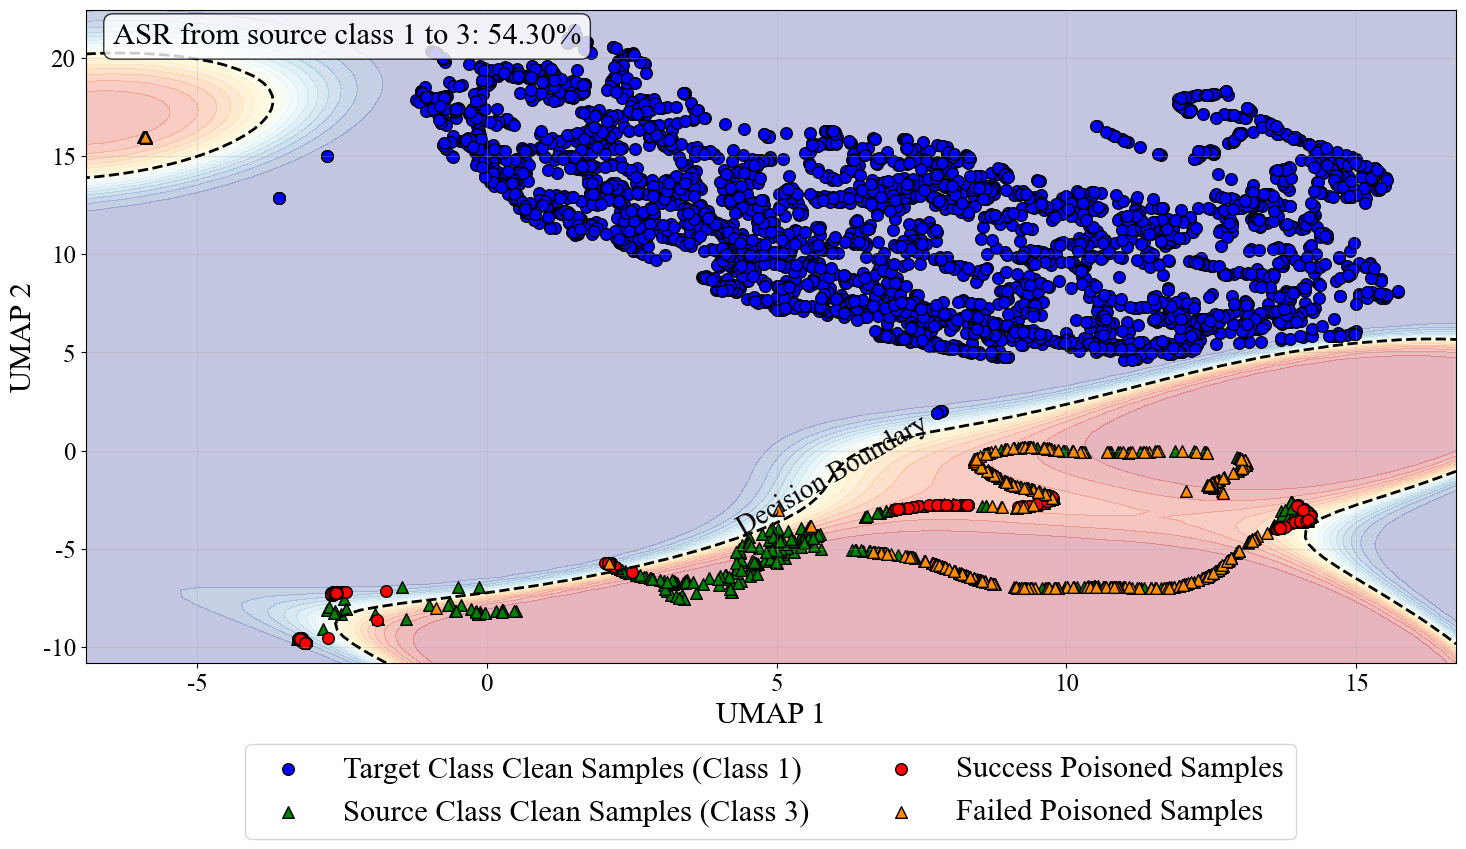

In [25]:
fig, embeddings = visualize_attack_boundary_umap_robust(
    x_clean_class_target,
    x_clean_class_original,
    x_triggered_right_target,
    x_triggered_wrong_target,
    umap_reducer,
    y_target, 
    y_clean,
    main_epoch=main_epoch,
    show_decision_boundary=True,
    boundary_method='svm'
)

# Samples visualization

In [ ]:
def plot_comparing_samples(original_sample, trigger_sample, y_clean, y_trigger):
    data_shape = original_sample.shape[1]
    
    # Create a figure with 2x2 subplots for 4 features
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()  # Flatten for easy indexing
    
    for i in range(data_shape):
        axes[i].plot(original_sample[:, i], label=f'Clean sample - Class: {y_clean}', color='blue', linewidth=2)
        axes[i].plot(trigger_sample[:, i], label=f'Trigger sample - Class: {y_trigger}', color='red', linewidth=2)
        axes[i].set_title(f'Feature {i+1} Comparison', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Add some statistics to each subplot
        diff = trigger_sample[:, i] - original_sample[:, i]
        max_diff = np.max(np.abs(diff))
        mean_diff = np.mean(np.abs(diff))
        
        # Calculate proportion of difference relative to original signal
        original_range = np.max(original_sample[:, i]) - np.min(original_sample[:, i])
        original_magnitude = np.mean(np.abs(original_sample[:, i]))
        
        # Avoid division by zero
        if original_range > 0:
            diff_range_ratio = max_diff / original_range
        else:
            diff_range_ratio = 0
            
        if original_magnitude > 0:
            diff_magnitude_ratio = mean_diff / original_magnitude
        else:
            diff_magnitude_ratio = 0
        
        # Add text box with difference statistics
        stats_text = (f'Max |Diff|: {max_diff:.4f}\n'
                     f'Mean |Diff|: {mean_diff:.4f}\n'
                     f'|Diff| / |Clean Magnitude|: {diff_magnitude_ratio*100:.2f}%\n')
        
        axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def visualize_data_distribution(x_to_poison, original_classes_target,
                                x_generated, triggered_classes_target,
                                method='tsne', 
                               sample_size=1000, figsize=(12, 5)):
    """
    Visualize distribution of x_to_poison and x_generated data using t-SNE or PCA
    
    Args:
        x_to_poison: Original data to be poisoned (list of arrays or 3D array)
        original_classes_target: Class labels for original data
        x_generated: Generated synthetic data (list of arrays or 3D array)
        triggered_classes_target: Class labels for generated data
        method: 'tsne', 'pca', or 'both'
        sample_size: Number of samples to use for visualization
        figsize: Figure size for plotting
    """
    
    # Prepare data
    def prepare_data(data, labels, sample_size):
        """Convert data to 2D array and keep corresponding labels"""
        if isinstance(data, list):
            # Convert list of arrays to single array
            data_concat = []
            for seq in data:
                # Flatten each sequence or take mean across time
                if len(seq.shape) == 2:  # (time_steps, features)
                    data_concat.append(seq.mean(axis=0))  # Average over time
                else:  # Already flattened
                    data_concat.append(seq)
            data_array = np.array(data_concat)
        else:
            # Handle 3D array (batch, time_steps, features)
            if len(data.shape) == 3:
                data_array = data.mean(axis=1)  # Average over time dimension
            else:
                data_array = data
        
        # Sample data if too large
        if len(data_array) > sample_size:
            indices = np.random.choice(len(data_array), sample_size, replace=False)
            data_array = data_array[indices]
            labels = labels[indices]
        
        return data_array, labels
    
    # Prepare both datasets
    poison_data, poison_labels = prepare_data(x_to_poison, original_classes_target, sample_size)
    generated_data, generated_labels = prepare_data(x_generated, triggered_classes_target, sample_size)
    
    # Combine data
    combined_data = np.vstack([poison_data, generated_data])
    combined_labels = np.concatenate([poison_labels, generated_labels])
    
    # Create source labels (0 for original, 1 for generated)
    source_labels = np.concatenate([
        np.zeros(len(poison_data)),  # Original data
        np.ones(len(generated_data))  # Generated data
    ])
    
    # Standardize data
    scaler = StandardScaler()
    combined_data_scaled = scaler.fit_transform(combined_data)
    
    print(f"Data shape: {combined_data_scaled.shape}")
    print(f"Original samples: {len(poison_data)}")
    print(f"Generated samples: {len(generated_data)}")
    
    # Choose visualization method
    if method.lower() == 'both':
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # PCA
        pca_result = apply_pca(combined_data_scaled, combined_labels, source_labels, ax1)
        
        # t-SNE
        tsne_result = apply_tsne(combined_data_scaled, combined_labels, source_labels, ax2)
        
        plt.tight_layout()
        
    elif method.lower() == 'pca':
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        pca_result = apply_pca(combined_data_scaled, combined_labels, source_labels, ax)
        
    elif method.lower() == 'tsne':
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        tsne_result = apply_tsne(combined_data_scaled, combined_labels, source_labels, ax)
    
    plt.show()
    
    return fig

def apply_pca(data, class_labels, source_labels, ax):
    """Apply PCA and plot results"""
    print("Computing PCA...")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    
    # Get unique classes and create color map
    unique_classes = np.unique(class_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))
    
    # Calculate proportions for legend labels
    total_original = np.sum(source_labels == 0)
    total_generated = np.sum(source_labels == 1)
    
    # Plot each class with different colors and markers based on source
    for i, class_label in enumerate(unique_classes):
        class_mask = class_labels == class_label
        
        # Original data (marker 'o')
        original_mask = class_mask & (source_labels == 0)
        if np.any(original_mask):
            count_original = np.sum(original_mask)
            prop_original = count_original / total_original * 100
            ax.scatter(pca_result[original_mask, 0], pca_result[original_mask, 1], 
                      c=[colors[i]], marker='o', 
                      label=f'Original Class {class_label} ({count_original}, {prop_original:.1f}%)', 
                      alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
        
        # Generated data (marker 'x')
        generated_mask = class_mask & (source_labels == 1)
        if np.any(generated_mask):
            count_generated = np.sum(generated_mask)
            prop_generated = count_generated / total_generated * 100
            ax.scatter(pca_result[generated_mask, 0], pca_result[generated_mask, 1], 
                      c=[colors[i]], marker='x', 
                      label=f'Generated Class {class_label} ({count_generated}, {prop_generated:.1f}%)', 
                      alpha=0.6, s=30)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax.set_title(f'PCA Visualization by Class, Target Class: {y_target}', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
    
    return pca_result

def apply_tsne(data, class_labels, source_labels, ax):
    """Apply t-SNE and plot results"""
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_result = tsne.fit_transform(data)
    
    # Get unique classes and create color map
    unique_classes = np.unique(class_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))
    
    # Calculate proportions for legend labels
    total_original = np.sum(source_labels == 0)
    total_generated = np.sum(source_labels == 1)
    
    # Plot each class with different colors and markers based on source
    for i, class_label in enumerate(unique_classes):
        class_mask = class_labels == class_label
        
        # Original data (marker 'o')
        original_mask = class_mask & (source_labels == 0)
        if np.any(original_mask):
            count_original = np.sum(original_mask)
            prop_original = count_original / total_original * 100
            ax.scatter(tsne_result[original_mask, 0], tsne_result[original_mask, 1], 
                      c=[colors[i]], marker='o', 
                      label=f'Original Class {class_label} ({count_original}, {prop_original:.1f}%)', 
                      alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
        
        # Generated data (marker 'x')
        generated_mask = class_mask & (source_labels == 1)
        if np.any(generated_mask):
            count_generated = np.sum(generated_mask)
            prop_generated = count_generated / total_generated * 100
            ax.scatter(tsne_result[generated_mask, 0], tsne_result[generated_mask, 1], 
                      c=[colors[i]], marker='x', 
                      label=f'Generated Class {class_label} ({count_generated}, {prop_generated:.1f}%)', 
                      alpha=0.6, s=30)
    
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title(f't-SNE Visualization by Class, Target Class: {y_target}', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    return tsne_result

In [ ]:
# fig1 = visualize_data_distribution(x_triggered, original_classes_target, x_triggered, triggered_classes_target, sample_size=1000, method='tsne')

# Other visualization

## Cosine Similarity

## Visualize the triggered samples

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_pattern_cosine_similarity(patterns):
    """
    Calculate cosine similarity between all patterns to analyze diversity
    
    Args:
        patterns: Generated patterns array with shape (n_samples, time_steps, features)
    
    Returns:
        similarity_matrix: Cosine similarity matrix
        similarities: Array of similarity values (upper triangle)
        similarity_stats: Dictionary with similarity statistics
    """
    
    # Flatten patterns for cosine similarity calculation
    # Shape: (n_samples, time_steps * features)
    flattened_patterns = patterns.reshape(len(patterns), -1)
    
    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(flattened_patterns)
    
    # Calculate statistics (excluding diagonal elements which are always 1.0)
    upper_triangle_mask = np.triu(np.ones_like(similarity_matrix, dtype=bool), k=1)
    similarities = similarity_matrix[upper_triangle_mask]
    
    similarity_stats = {
        'mean': np.mean(similarities),
        'std': np.std(similarities),
        'min': np.min(similarities),
        'max': np.max(similarities),
        'median': np.median(similarities),
        'q25': np.percentile(similarities, 25),
        'q75': np.percentile(similarities, 75)
    }
    
    return similarity_matrix, similarities, similarity_stats

def plot_similarity_analysis(similarity_matrix, similarities, similarity_stats, figsize=(15, 5)):
    """
    Plot similarity analysis results
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot 1: Box plot of similarities
    axes[0].boxplot([similarities], labels=['Pattern Similarities'])
    axes[0].set_ylabel('Cosine Similarity')
    axes[0].set_title('Pattern Similarity Box Plot')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Similarity distribution histogram
    axes[1].hist(similarities, bins=50, alpha=0.7, density=True)
    axes[1].axvline(similarity_stats['mean'], color='red', linestyle='--', 
                   label=f"Mean: {similarity_stats['mean']:.3f}")
    axes[1].axvline(similarity_stats['median'], color='orange', linestyle='--', 
                   label=f"Median: {similarity_stats['median']:.3f}")
    axes[1].set_xlabel('Cosine Similarity')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Distribution of Pattern Similarities')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)


    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("=== Pattern Similarity Statistics ===")
    print(f"Total number of patterns: {len(similarity_matrix):,}")
    print(f"Number of pattern pairs analyzed: {len(similarities):,}")
    print(f"Mean cosine similarity: {similarity_stats['mean']:.4f}")
    print(f"Standard deviation: {similarity_stats['std']:.4f}")
    print(f"Median similarity: {similarity_stats['median']:.4f}")
    print(f"Min similarity: {similarity_stats['min']:.4f}")
    print(f"Max similarity: {similarity_stats['max']:.4f}")
    print(f"25th percentile: {similarity_stats['q25']:.4f}")
    print(f"75th percentile: {similarity_stats['q75']:.4f}")
    
    # Diversity interpretation
    if similarity_stats['mean'] < 0.3:
        diversity_level = "High diversity (low similarity)"
    elif similarity_stats['mean'] < 0.7:
        diversity_level = "Moderate diversity"
    else:
        diversity_level = "Low diversity (high similarity)"
    
    print(f"\nPattern Diversity Assessment: {diversity_level}")
    print(f"Interpretation: Lower similarity values indicate more diverse patterns")

In [ ]:
# Calculate and analyze pattern similarity for all patterns
# similarity_matrix, similarities, similarity_stats = calculate_pattern_cosine_similarity(x_test_triggered)
# plot_similarity_analysis(similarity_matrix, similarities, similarity_stats)

In [ ]:
# ...existing code...
def visualize_single_sample_channel(
    x_triggered,
    sample_index: int,
    channel: int,
    color: str = "red",
    title: str = None,          # kept for backward compatibility (ignored)
    ax=None,
    ylim: tuple | None = None   # (<ymin>, <ymax>) value limits
):
    """
    Visualize ONE triggered sample (single channel) without title or axis labels.

    Args:
        x_triggered: array (n_samples, time_steps, n_channels)
        sample_index: which sample to plot
        channel: channel index
        color: line color
        ylim: optional (ymin, ymax) value range to focus on
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if x_triggered.ndim != 3:
        raise ValueError(f"Expected shape (n_samples, time, channels); got {x_triggered.shape}")
    n_samples, time_steps, n_channels = x_triggered.shape
    if not (0 <= sample_index < n_samples):
        raise IndexError(f"sample_index {sample_index} out of range (0..{n_samples-1})")
    if not (0 <= channel < n_channels):
        raise IndexError(f"channel {channel} out of range (0..{n_channels-1})")

    sample = x_triggered[sample_index, :, channel]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    else:
        fig = ax.figure

    ax.plot(sample, color=color, linewidth=2)
    ax.grid(alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if ylim is not None:
        if len(ylim) != 2:
            raise ValueError("ylim must be a tuple (ymin, ymax)")
        ymin, ymax = ylim
        if ymin is not None and ymax is not None and ymin >= ymax:
            raise ValueError("ylim invalid: ymin must be < ymax")
        ax.set_ylim(ymin, ymax)

    return ax

In [ ]:
noise_generator = TriggerGenerator(
    output_directory = None,
    generator_config = generator_configs["blackbox"][surro_clf_name][dataset_name],
    max_amplitude = 0.05,
    input_shape = input_shape,
    enc = enc
)
noise_generator.generator.load_weights(gen_weight_path)
noise_generator.generator.trainable = False

In [ ]:
x_triggered_visual = noise_generator.apply_trigger(x_test_sp)

In [ ]:
sample_index = 1000
visualize_single_sample_channel(x_triggered_visual, sample_index=sample_index, channel=2, color="#E74C3C")
plt.show()

visualize_single_sample_channel(x_test_sp, sample_index=sample_index, channel=2, color="#008000")
plt.show()